# Dependencies
Install required packages (skip if already installed).

In [1]:
%pip install -r requirements.txt


Note: you may need to restart the kernel to use updated packages.


# Environment setup
Load .env overrides, configure dataset/devices, and load or train the PPO policy + ThresholdRefinementEnv.

In [2]:
import os
from pathlib import Path

from dotenv import load_dotenv
from stable_baselines3 import PPO
from envionments.threshold_refinement import ThresholdRefinementEnv
from utility.dataset import load_pascal_voc2007, load_custom_dataset
from utility.torch_utils import get_default_device
from utility.logging_utils import setup_logging
from utility.evaluation import evaluate_policy, summarize_stats, EvalHistoryCallback

# Load .env but do not override pre-set values in this runtime
load_dotenv(".env", override=False)
setup_logging()

# Defaults for more credible runs and GPU usage (Metal on macOS)
os.environ.setdefault("RL_DATA_LIMIT", "1000")
os.environ.setdefault("RL_TOTAL_TIMESTEPS", "50000")
os.environ.setdefault("RL_EVAL_EPISODES", "10")
os.environ.setdefault("RL_LEARNING_RATE", "3e-4")
os.environ.setdefault("RL_DEVICE", "cpu")
os.environ.setdefault("DETECTOR_DEVICE", "mps")
# Model-agnostic post-processing knobs
os.environ.setdefault("RL_NMS_IOU", "0.7")
os.environ.setdefault("RL_INIT_THRESH_LOW", "0.1")
os.environ.setdefault("RL_INIT_THRESH_HIGH", "0.6")
os.environ.setdefault("RL_MAX_DET", "200")
os.environ.setdefault("RL_MAX_NMS_DELTA", "0.1")

VOC_ROOT = os.getenv("VOC_ROOT", "data/voc")
IMAGE_DIR = os.getenv("IMAGE_DIR")
LABEL_DIR = os.getenv("LABEL_DIR")
DATA_LIMIT = int(os.getenv("RL_DATA_LIMIT", "1000"))
TOTAL_TIMESTEPS = int(os.getenv("RL_TOTAL_TIMESTEPS", "50000"))
LEARNING_RATE = float(os.getenv("RL_LEARNING_RATE", "3e-4"))
MODEL_PATH = os.getenv("RL_MODEL_PATH", "rl_threshold_tuner.zip")

# Stronger env knobs for learning signal
ENV_KWARGS = {
    "max_delta": float(os.getenv("RL_MAX_DELTA", "0.15")),
    "max_steps": int(os.getenv("RL_MAX_STEPS", "20")),
    "initial_threshold_range": (
        float(os.getenv("RL_INIT_THRESH_LOW", "0.1")),
        float(os.getenv("RL_INIT_THRESH_HIGH", "0.6")),
    ),
    "box_count_penalty": float(os.getenv("RL_BOX_COUNT_PENALTY", "0.05")),
    "initial_nms_iou": float(os.getenv("RL_NMS_IOU", "0.7")),
    "max_det": int(os.getenv("RL_MAX_DET", "200")),
    "max_nms_delta": float(os.getenv("RL_MAX_NMS_DELTA", "0.1")),
    "fbeta": float(os.getenv("RL_F_BETA", "3.0")),
    "fn_penalty": float(os.getenv("RL_FN_PENALTY", "0.2")),
}

POLICY_DEVICE = get_default_device(env_var="RL_DEVICE")
DETECTOR_DEVICE = get_default_device(env_var="DETECTOR_DEVICE")

if IMAGE_DIR:
    dataset = load_custom_dataset(
        IMAGE_DIR,
        LABEL_DIR or IMAGE_DIR,
        annotation_format="yolo_txt",
        limit=DATA_LIMIT,
    )
else:
    dataset = load_pascal_voc2007(
        VOC_ROOT, image_set="trainval", limit=DATA_LIMIT, download=True
    )

env = ThresholdRefinementEnv(dataset, device=POLICY_DEVICE, detector_device=DETECTOR_DEVICE, **ENV_KWARGS)

def make_eval_callback(model):
    return EvalHistoryCallback(
        eval_fn=lambda: summarize_stats(
            evaluate_policy(
                model,
                dataset,
                episodes=3,
                deterministic=True,
                device=POLICY_DEVICE,
                detector_device=DETECTOR_DEVICE,
                env_kwargs=ENV_KWARGS,
            )
        ),
        eval_freq=5000,
        name="eval",
    )

cb = None
if Path(MODEL_PATH).exists():
    try:
        model = PPO.load(MODEL_PATH, device=POLICY_DEVICE)
        model.set_env(env)
        cb = make_eval_callback(model)
        print(f"Loaded existing model from {MODEL_PATH}")
    except ValueError as err:
        print(f"Model at {MODEL_PATH} incompatible with current env ({err}); retraining.")
        model = PPO("MlpPolicy", env, verbose=1, learning_rate=LEARNING_RATE, n_steps=512, device=POLICY_DEVICE)
        cb = make_eval_callback(model)
        model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=cb)
        model.save(MODEL_PATH)
        print(f"Trained and saved model to {MODEL_PATH}")
else:
    model = PPO("MlpPolicy", env, verbose=1, learning_rate=LEARNING_RATE, n_steps=512, device=POLICY_DEVICE)
    cb = make_eval_callback(model)
    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=cb)
    model.save(MODEL_PATH)
    print(f"Trained and saved model to {MODEL_PATH}")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10       |
|    ep_rew_mean     | 2.36     |
| time/              |          |
|    fps             | 19       |
|    iterations      | 1        |
|    time_elapsed    | 26       |
|    total_timesteps | 512      |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | 2.77        |
| time/                   |             |
|    fps                  | 25          |
|    iterations           | 2           |
|    time_elapsed         | 40          |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.009251223 |
|    clip_fraction        | 0.0477      |
|    clip_range           | 0.2         |
|    entropy_loss   

2025-12-22 19:15:02,192 | INFO | utility.evaluation | Evaluation summary: episodes=3 mean_final_iou=0.2782 std_final_iou=0.4029 mean_return=2.6403 mean_steps=10.00 mean_final_threshold=0.577 mean_final_nms=0.519
2025-12-22 19:15:02,192 | INFO | utility.evaluation | eval @ 5000 steps: mean_final_iou=0.2782 mean_return=2.6403


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10           |
|    ep_rew_mean          | 5.39         |
| time/                   |              |
|    fps                  | 33           |
|    iterations           | 10           |
|    time_elapsed         | 153          |
|    total_timesteps      | 5120         |
| train/                  |              |
|    approx_kl            | 0.0052019465 |
|    clip_fraction        | 0.00996      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.79        |
|    explained_variance   | 0.679        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.32         |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.00501     |
|    std                  | 0.973        |
|    value_loss           | 6.28         |
------------------------------------------
-----------------------------------------
| rollout/  

2025-12-22 19:17:22,556 | INFO | utility.evaluation | Evaluation summary: episodes=3 mean_final_iou=0.4774 std_final_iou=0.3584 mean_return=5.4908 mean_steps=10.00 mean_final_threshold=0.474 mean_final_nms=0.500
2025-12-22 19:17:22,556 | INFO | utility.evaluation | eval @ 10000 steps: mean_final_iou=0.4774 mean_return=5.4908


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | 5.61        |
| time/                   |             |
|    fps                  | 34          |
|    iterations           | 20          |
|    time_elapsed         | 297         |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.007543603 |
|    clip_fraction        | 0.0287      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.76       |
|    explained_variance   | 0.399       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.91        |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.00458    |
|    std                  | 0.961       |
|    value_loss           | 5.46        |
-----------------------------------------
-----------------------------------------
| rollout/                |       

2025-12-22 19:19:56,642 | INFO | utility.evaluation | Evaluation summary: episodes=3 mean_final_iou=0.0786 std_final_iou=0.2767 mean_return=1.2933 mean_steps=10.00 mean_final_threshold=0.419 mean_final_nms=0.500
2025-12-22 19:19:56,642 | INFO | utility.evaluation | eval @ 15000 steps: mean_final_iou=0.0786 mean_return=1.2933


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | 4.93        |
| time/                   |             |
|    fps                  | 33          |
|    iterations           | 30          |
|    time_elapsed         | 455         |
|    total_timesteps      | 15360       |
| train/                  |             |
|    approx_kl            | 0.005896787 |
|    clip_fraction        | 0.0408      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.72       |
|    explained_variance   | 0.685       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.62        |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.00807    |
|    std                  | 0.942       |
|    value_loss           | 7.72        |
-----------------------------------------
------------------------------------------
| rollout/                |      

2025-12-22 19:22:43,545 | INFO | utility.evaluation | Evaluation summary: episodes=3 mean_final_iou=0.5045 std_final_iou=0.2297 mean_return=4.9744 mean_steps=10.00 mean_final_threshold=0.445 mean_final_nms=0.500
2025-12-22 19:22:43,545 | INFO | utility.evaluation | eval @ 20000 steps: mean_final_iou=0.5045 mean_return=4.9744


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | 5.7         |
| time/                   |             |
|    fps                  | 32          |
|    iterations           | 40          |
|    time_elapsed         | 627         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.009157939 |
|    clip_fraction        | 0.0785      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.7        |
|    explained_variance   | 0.848       |
|    learning_rate        | 0.0003      |
|    loss                 | 4.32        |
|    n_updates            | 390         |
|    policy_gradient_loss | -0.00773    |
|    std                  | 0.935       |
|    value_loss           | 7.67        |
-----------------------------------------
-----------------------------------------
| rollout/                |       

2025-12-22 19:25:21,864 | INFO | utility.evaluation | Evaluation summary: episodes=3 mean_final_iou=0.9141 std_final_iou=0.0681 mean_return=9.1409 mean_steps=10.00 mean_final_threshold=0.524 mean_final_nms=0.500
2025-12-22 19:25:21,864 | INFO | utility.evaluation | eval @ 25000 steps: mean_final_iou=0.9141 mean_return=9.1409


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | 5.53        |
| time/                   |             |
|    fps                  | 32          |
|    iterations           | 49          |
|    time_elapsed         | 772         |
|    total_timesteps      | 25088       |
| train/                  |             |
|    approx_kl            | 0.005327367 |
|    clip_fraction        | 0.0271      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.72       |
|    explained_variance   | 0.758       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.67        |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.0039     |
|    std                  | 0.944       |
|    value_loss           | 6.18        |
-----------------------------------------
-----------------------------------------
| rollout/                |       

2025-12-22 19:27:46,389 | INFO | utility.evaluation | Evaluation summary: episodes=3 mean_final_iou=0.4137 std_final_iou=0.2464 mean_return=4.6944 mean_steps=10.00 mean_final_threshold=0.553 mean_final_nms=0.500
2025-12-22 19:27:46,390 | INFO | utility.evaluation | eval @ 30000 steps: mean_final_iou=0.4137 mean_return=4.6944


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10           |
|    ep_rew_mean          | 5.41         |
| time/                   |              |
|    fps                  | 32           |
|    iterations           | 59           |
|    time_elapsed         | 923          |
|    total_timesteps      | 30208        |
| train/                  |              |
|    approx_kl            | 0.0042916443 |
|    clip_fraction        | 0.0209       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.71        |
|    explained_variance   | 0.866        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.44         |
|    n_updates            | 580          |
|    policy_gradient_loss | -0.0021      |
|    std                  | 0.939        |
|    value_loss           | 5.85         |
------------------------------------------
----------------------------------------
| rollout/   

2025-12-22 19:30:09,860 | INFO | utility.evaluation | Evaluation summary: episodes=3 mean_final_iou=0.2540 std_final_iou=0.1978 mean_return=0.9884 mean_steps=10.00 mean_final_threshold=0.393 mean_final_nms=0.500
2025-12-22 19:30:09,861 | INFO | utility.evaluation | eval @ 35000 steps: mean_final_iou=0.2540 mean_return=0.9884


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10           |
|    ep_rew_mean          | 5.95         |
| time/                   |              |
|    fps                  | 33           |
|    iterations           | 69           |
|    time_elapsed         | 1066         |
|    total_timesteps      | 35328        |
| train/                  |              |
|    approx_kl            | 0.0078098034 |
|    clip_fraction        | 0.0961       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.68        |
|    explained_variance   | 0.937        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.14         |
|    n_updates            | 680          |
|    policy_gradient_loss | -0.00572     |
|    std                  | 0.924        |
|    value_loss           | 3.1          |
------------------------------------------
-----------------------------------------
| rollout/  

2025-12-22 19:32:21,702 | INFO | utility.evaluation | Evaluation summary: episodes=3 mean_final_iou=0.7467 std_final_iou=0.1519 mean_return=5.7062 mean_steps=10.00 mean_final_threshold=0.370 mean_final_nms=0.500
2025-12-22 19:32:21,703 | INFO | utility.evaluation | eval @ 40000 steps: mean_final_iou=0.7467 mean_return=5.7062


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | 5.22        |
| time/                   |             |
|    fps                  | 33          |
|    iterations           | 79          |
|    time_elapsed         | 1201        |
|    total_timesteps      | 40448       |
| train/                  |             |
|    approx_kl            | 0.011152991 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.6        |
|    explained_variance   | 0.763       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.63        |
|    n_updates            | 780         |
|    policy_gradient_loss | -0.0158     |
|    std                  | 0.885       |
|    value_loss           | 2.76        |
-----------------------------------------
-----------------------------------------
| rollout/                |       

2025-12-22 19:34:46,809 | INFO | utility.evaluation | Evaluation summary: episodes=3 mean_final_iou=0.6103 std_final_iou=0.3652 mean_return=6.1817 mean_steps=10.00 mean_final_threshold=0.405 mean_final_nms=0.500
2025-12-22 19:34:46,810 | INFO | utility.evaluation | eval @ 45000 steps: mean_final_iou=0.6103 mean_return=6.1817


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10           |
|    ep_rew_mean          | 5.38         |
| time/                   |              |
|    fps                  | 33           |
|    iterations           | 88           |
|    time_elapsed         | 1336         |
|    total_timesteps      | 45056        |
| train/                  |              |
|    approx_kl            | 0.0061202245 |
|    clip_fraction        | 0.0443       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.58        |
|    explained_variance   | 0.878        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.08         |
|    n_updates            | 870          |
|    policy_gradient_loss | -0.00649     |
|    std                  | 0.877        |
|    value_loss           | 2.68         |
------------------------------------------
-----------------------------------------
| rollout/  

2025-12-22 19:37:25,252 | INFO | utility.evaluation | Evaluation summary: episodes=3 mean_final_iou=0.8353 std_final_iou=0.1517 mean_return=7.1855 mean_steps=10.00 mean_final_threshold=0.356 mean_final_nms=0.500
2025-12-22 19:37:25,252 | INFO | utility.evaluation | eval @ 50000 steps: mean_final_iou=0.8353 mean_return=7.1855


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 10           |
|    ep_rew_mean          | 5.35         |
| time/                   |              |
|    fps                  | 33           |
|    iterations           | 98           |
|    time_elapsed         | 1498         |
|    total_timesteps      | 50176        |
| train/                  |              |
|    approx_kl            | 0.0046654255 |
|    clip_fraction        | 0.04         |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.5         |
|    explained_variance   | 0.919        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.96         |
|    n_updates            | 970          |
|    policy_gradient_loss | -0.00546     |
|    std                  | 0.845        |
|    value_loss           | 3.3          |
------------------------------------------
Trained and saved model to rl_threshold_tuner.zip


# Evaluate policy
Run evaluation rollouts on the dataset and print summary IoU stats.

2025-12-22 19:37:36,459 | INFO | utility.evaluation | Evaluation summary: episodes=20 mean_final_iou=0.5524 std_final_iou=0.3453 mean_return=5.3020 mean_steps=10.00 mean_final_threshold=0.330 mean_final_nms=0.500


Episodes: 20
Mean final IoU: 0.5524 +/- 0.3453
Mean matched IoU: 0.8767 +/- 0.0958
Mean final F1: 0.7265 +/- 0.2886
Mean final precision: 0.8220 +/- 0.2285
Mean final recall: 0.7290 +/- 0.2988
Mean return: 5.3020
Mean steps: 10.00
Per-episode final IoUs: [0.8912, 0.0549, 0.8349, 0.3897, 0.9213, 0.9739, -0.0336, 0.3151, 0.8165, 0.968, 0.4993, 0.3594, -0.1089, 0.9158, 0.5282, 0.9547, 0.4603, 0.2339, 0.3402, 0.7333]


<Axes: title={'center': 'Threshold trajectory per evaluation episode'}, xlabel='Step', ylabel='Confidence threshold'>

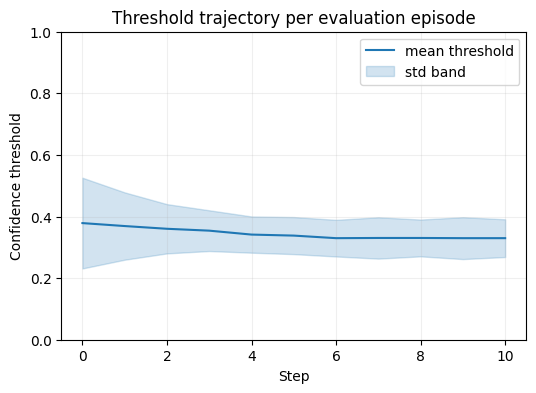

In [3]:
import os

from dotenv import load_dotenv
from utility.evaluation import evaluate_policy, summarize_stats, plot_threshold_trajectories

load_dotenv(".env", override=False)
os.environ.setdefault("RL_EVAL_EPISODES", "10")
EVAL_EPISODES = int(os.getenv("RL_EVAL_EPISODES", "10"))

stats = evaluate_policy(
    model,
    dataset,
    episodes=EVAL_EPISODES,
    device=POLICY_DEVICE,
    detector_device=DETECTOR_DEVICE,
    env_kwargs=ENV_KWARGS,
)
summary = summarize_stats(stats)
print("Episodes:", summary["episodes"])
print(f"Mean final IoU: {summary['mean_final_iou']:.4f} +/- {summary['std_final_iou']:.4f}")
print(f"Mean matched IoU: {summary['mean_final_matched_iou']:.4f} +/- {summary['std_final_matched_iou']:.4f}")
print(f"Mean final F1: {summary['mean_final_f1']:.4f} +/- {summary['std_final_f1']:.4f}")
print(f"Mean final precision: {summary['mean_final_precision']:.4f} +/- {summary['std_final_precision']:.4f}")
print(f"Mean final recall: {summary['mean_final_recall']:.4f} +/- {summary['std_final_recall']:.4f}")
print(f"Mean return: {summary['mean_return']:.4f}")
print(f"Mean steps: {summary['mean_steps']:.2f}")
print("Per-episode final IoUs:", [round(s.final_iou, 4) for s in stats])

plot_threshold_trajectories(stats, aggregate=True, show_std_band=True)


# Policy vs baseline metrics
Compare detection quality on the same images used for policy evaluation.


In [4]:
from utility.evaluation import evaluate_baseline_detection_metrics

baseline_metrics = evaluate_baseline_detection_metrics(
    stats,
    dataset,
    baseline_threshold=0.5,
    baseline_nms_iou=float(ENV_KWARGS.get("initial_nms_iou", 0.7)),
    baseline_max_det=int(ENV_KWARGS.get("max_det", 200)),
    detector_device=DETECTOR_DEVICE,
)

policy_metrics = {
    "mean_precision": summary.get("mean_final_precision", 0.0),
    "mean_recall": summary.get("mean_final_recall", 0.0),
    "mean_f1": summary.get("mean_final_f1", 0.0),
    "mean_matched_iou": summary.get("mean_final_matched_iou", 0.0),
}

print("Policy vs baseline metrics (same images):")
for key in ["mean_precision", "mean_recall", "mean_f1", "mean_matched_iou"]:
    print(f"{key}: policy={policy_metrics[key]:.4f} baseline={baseline_metrics[key]:.4f}")


Policy vs baseline metrics (same images):
mean_precision: policy=0.8220 baseline=0.6720
mean_recall: policy=0.7290 baseline=0.5523
mean_f1: policy=0.7265 baseline=0.5818
mean_matched_iou: policy=0.8767 baseline=0.7706


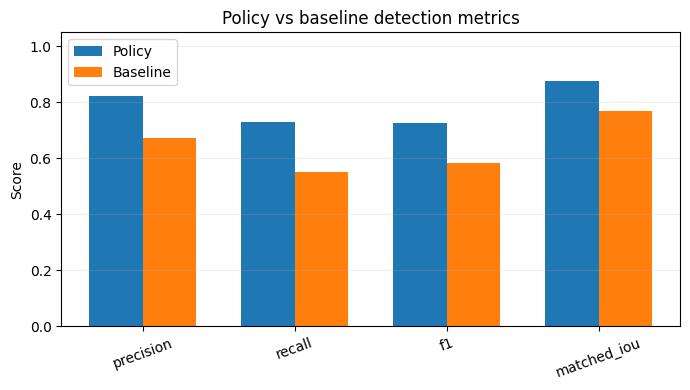

In [5]:
import matplotlib.pyplot as plt

keys = ["mean_precision", "mean_recall", "mean_f1", "mean_matched_iou"]
policy_vals = [policy_metrics[k] for k in keys]
baseline_vals = [baseline_metrics[k] for k in keys]

x = range(len(keys))
width = 0.35
fig, ax = plt.subplots(figsize=(7, 4))
ax.bar([i - width / 2 for i in x], policy_vals, width, label="Policy")
ax.bar([i + width / 2 for i in x], baseline_vals, width, label="Baseline")
ax.set_xticks(list(x))
ax.set_xticklabels([k.replace("mean_", "") for k in keys], rotation=20)
ax.set_ylim(0.0, 1.05)
ax.set_ylabel("Score")
ax.set_title("Policy vs baseline detection metrics")
ax.legend()
ax.grid(True, axis="y", alpha=0.2)
plt.tight_layout()


# Per-episode diagnostics
Plot threshold, IoU, and reward trajectories, plus the final IoU distribution.

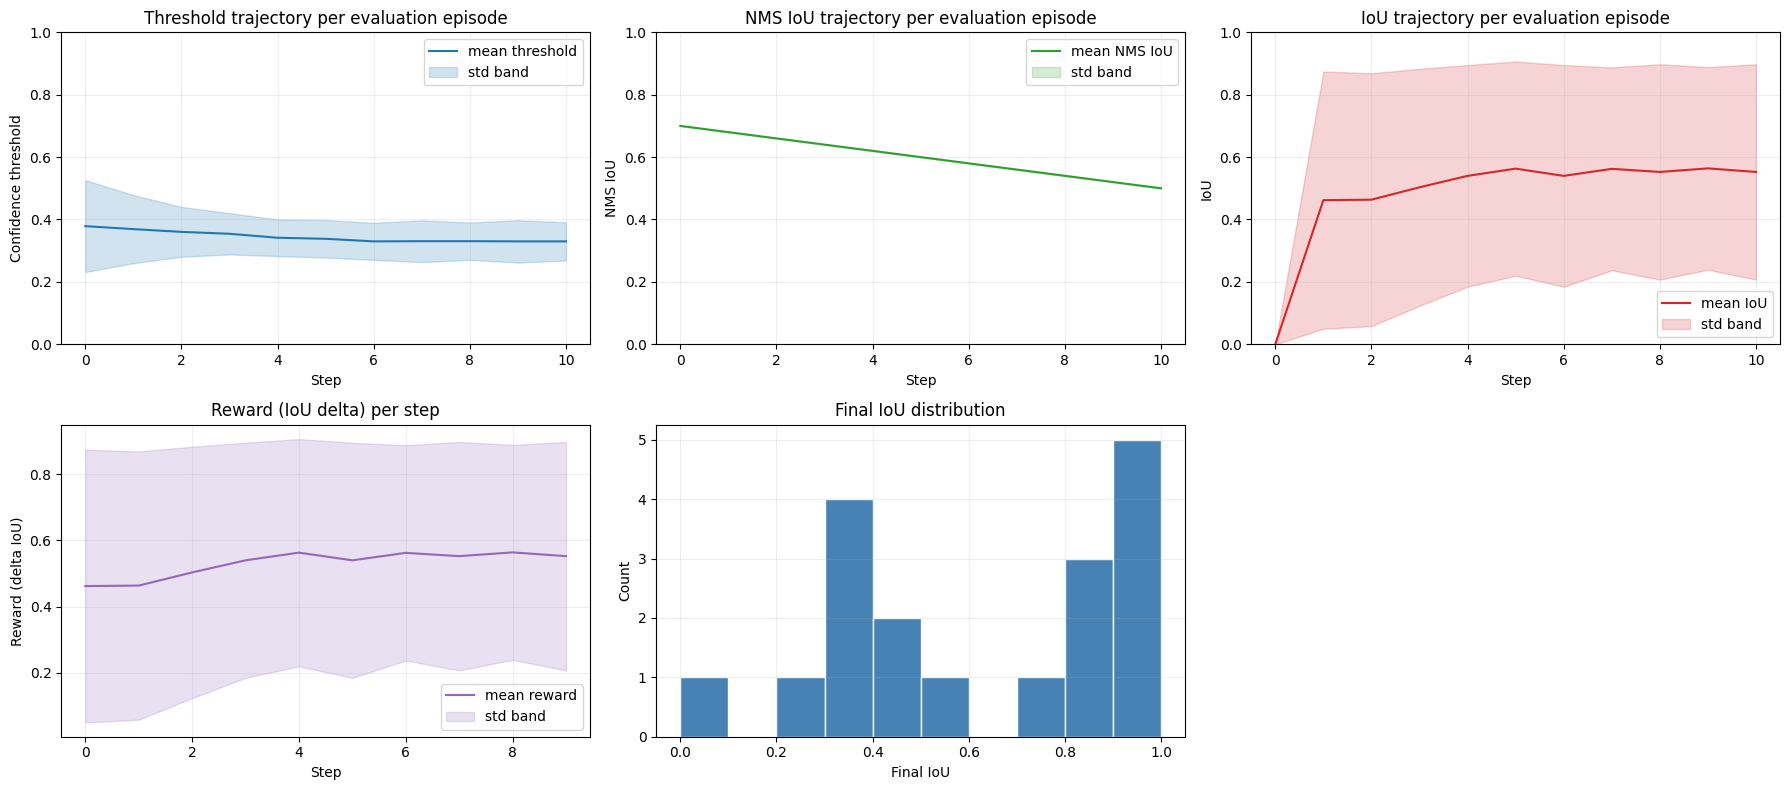

In [6]:
import matplotlib.pyplot as plt
from utility.evaluation import (
    plot_threshold_trajectories,
    plot_iou_trajectories,
    plot_reward_trajectories,
    plot_final_iou_histogram,
    plot_nms_trajectories,
)
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
PLOT_MAX_EPISODES = 12
plot_threshold_trajectories(stats, ax=axes[0, 0], aggregate=True, show_std_band=True)
plot_nms_trajectories(stats, ax=axes[0, 1], aggregate=True, show_std_band=True)
plot_iou_trajectories(stats, ax=axes[0, 2], aggregate=True, show_std_band=True)
plot_reward_trajectories(stats, ax=axes[1, 0], aggregate=True, show_std_band=True)
plot_final_iou_histogram(stats, ax=axes[1, 1])
axes[1, 2].axis("off")
plt.tight_layout()


# Detection-count accuracy vs baseline
Compare how well the policy vs a fixed-threshold YOLO match the ground-truth box count.

# Learning curve
Plot mean_final_iou and mean_return tracked during training.

<Axes: title={'center': 'Learning curve (evaluation)'}, xlabel='Timesteps', ylabel='Score'>

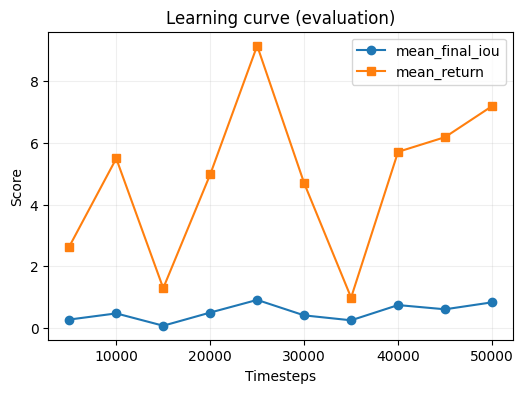

In [8]:
from utility.evaluation import plot_learning_curve

# Plot learning curve from callback history
fig, ax = plt.subplots(figsize=(6,4))
plot_learning_curve(cb.history, ax=ax)


## Compare RL policy vs baseline YOLO

Run quantitative baselines at fixed thresholds and plot qualitative side-by-side detections.

### Quantitative baseline comparison
Evaluate the saved policy against multiple fixed-confidence baselines; adjust COMPAR* env vars to change the sweep.

2025-12-22 19:37:38,545 | INFO | utility.model_comparison | Using VOC2007 root=./data/voc limit=500
2025-12-22 19:37:38,546 | INFO | utility.model_comparison | Running comparison on dataset=voc2007(./data/voc) episodes=20 thresholds=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
2025-12-22 19:37:43,813 | INFO | utility.evaluation | Evaluation summary: episodes=20 mean_final_iou=0.6771 std_final_iou=0.2185 mean_return=6.3873 mean_steps=10.00 mean_final_threshold=0.321 mean_final_nms=0.500
2025-12-22 19:37:43,885 | INFO | utility.model_comparison | Evaluating baseline at threshold=0.20
2025-12-22 19:37:57,683 | INFO | utility.model_comparison | Evaluating baseline at threshold=0.30
2025-12-22 19:38:12,243 | INFO | utility.model_comparison | Evaluating baseline at threshold=0.40
2025-12-22 19:38:26,069 | INFO | utility.model_comparison | Evaluating baseline at threshold=0.50
2025-12-22 19:38:40,074 | INFO | utility.model_comparison | Evaluating baseline at threshold=0.60
2025-12-22 19:38:53,546 | IN

{
  "dataset": "voc2007(./data/voc)",
  "episodes": 20,
  "rl": {
    "episodes": 20,
    "mean_final_iou": 0.6771264672279358,
    "std_final_iou": 0.2184906303882599,
    "mean_return": 6.387312889099121,
    "mean_steps": 10.0,
    "mean_final_threshold": 0.32074129581451416,
    "std_final_threshold": 0.06735052168369293,
    "mean_final_nms_iou": 0.5,
    "std_final_nms_iou": 0.0,
    "mean_final_precision": 0.8855555653572083,
    "std_final_precision": 0.18298281729221344,
    "mean_final_recall": 0.8159849047660828,
    "std_final_recall": 0.24969424307346344,
    "mean_final_f1": 0.805700957775116,
    "std_final_f1": 0.2182953804731369,
    "mean_final_matched_iou": 0.8625582456588745,
    "std_final_matched_iou": 0.07223039120435715
  },
  "rl_meta": {
    "per_episode_thresholds": [
      0.31599798798561096,
      0.3121388554573059,
      0.4000000059604645,
      0.32209640741348267,
      0.30000001192092896,
      0.30000001192092896,
      0.19999998807907104,
      0

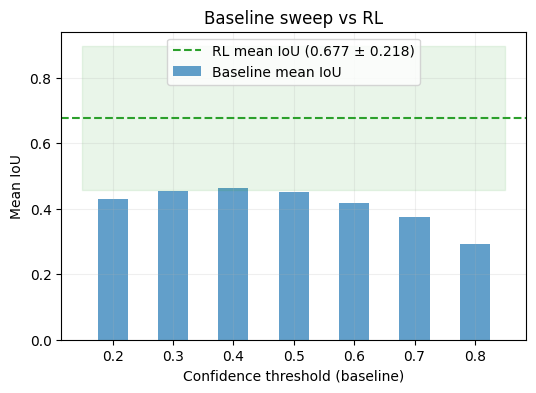

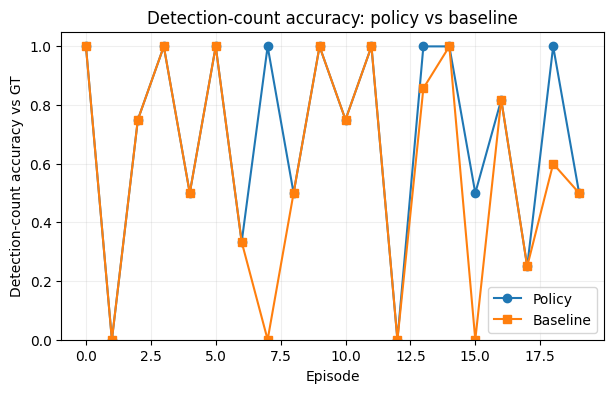

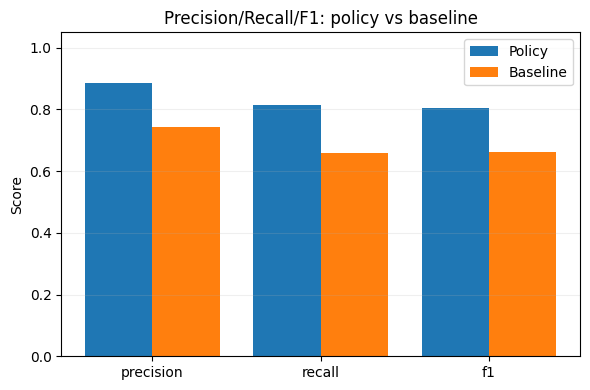

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from dotenv import load_dotenv
from utility.model_comparison import compare_models

# Lightweight comparison controls (tune here instead of editing code)
load_dotenv('.env', override=False)
COMPARE_DATA_LIMIT = int(os.getenv('COMPARE_DATA_LIMIT', '100'))
COMPARE_EPISODES = int(os.getenv('COMPARE_EPISODES', '3'))
COMPARE_THRESHOLDS = [float(t) for t in os.getenv('COMPARE_THRESHOLDS', '0.3,0.5,0.7').split(',')]

comparison = compare_models(
    model_path=MODEL_PATH,
    episodes=COMPARE_EPISODES,
    dataset_limit=COMPARE_DATA_LIMIT,
    thresholds=COMPARE_THRESHOLDS,
)
print(json.dumps(comparison, indent=2))


# Plot baseline sweep vs RL mean IoU
baseline_points = comparison['baseline']['per_threshold']
t_vals = [p['threshold'] for p in baseline_points]
baseline_iou = [p['mean_iou'] for p in baseline_points]
rl_mean = comparison['rl']['mean_final_iou']
rl_std = comparison['rl']['std_final_iou']
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(t_vals, baseline_iou, width=0.05, color='tab:blue', alpha=0.7, label='Baseline mean IoU')
ax.axhline(rl_mean, color='tab:green', linestyle='--', label=f'RL mean IoU ({rl_mean:.3f} ± {rl_std:.3f})')
ax.fill_between([min(t_vals)-0.05, max(t_vals)+0.05], rl_mean-rl_std, rl_mean+rl_std, color='tab:green', alpha=0.1)
ax.set_xlabel('Confidence threshold (baseline)')
ax.set_ylabel('Mean IoU')
ax.set_title('Baseline sweep vs RL')
ax.legend()
ax.grid(True, alpha=0.2)

# Detection count accuracy comparison
count = comparison.get("detection_count_accuracy", {})
episodes = count.get("episodes", [])
rl_acc = count.get("rl_acc", [])
base_acc = count.get("baseline_acc", [])
if episodes:
    fig, ax = plt.subplots(figsize=(7,4))
    ax.plot(episodes, rl_acc, marker="o", label="Policy")
    ax.plot(episodes, base_acc, marker="s", label="Baseline")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Detection-count accuracy vs GT")
    ax.set_ylim(0.0, 1.05)
    ax.set_title("Detection-count accuracy: policy vs baseline")
    ax.grid(True, alpha=0.2)
    ax.legend()

# Precision/recall/F1 comparison
baseline_metrics = comparison.get("baseline_detection_metrics", {})
policy_metrics = {
    "precision": comparison["rl"].get("mean_final_precision", 0.0),
    "recall": comparison["rl"].get("mean_final_recall", 0.0),
    "f1": comparison["rl"].get("mean_final_f1", 0.0),
}
baseline_vals = [
    baseline_metrics.get("mean_precision", 0.0),
    baseline_metrics.get("mean_recall", 0.0),
    baseline_metrics.get("mean_f1", 0.0),
]
labels = ["precision", "recall", "f1"]
x = range(len(labels))
fig, ax = plt.subplots(figsize=(6,4))
ax.bar([i - 0.2 for i in x], [policy_metrics[k] for k in labels], width=0.4, label="Policy")
ax.bar([i + 0.2 for i in x], baseline_vals, width=0.4, label="Baseline")
ax.set_xticks(list(x))
ax.set_xticklabels(labels)
ax.set_ylim(0.0, 1.05)
ax.set_ylabel("Score")
ax.set_title("Precision/Recall/F1: policy vs baseline")
ax.grid(True, axis="y", alpha=0.2)
ax.legend()
plt.tight_layout()


### Qualitative policy vs baseline visualization
Show policy detections at the learned threshold alongside a fixed-threshold baseline.

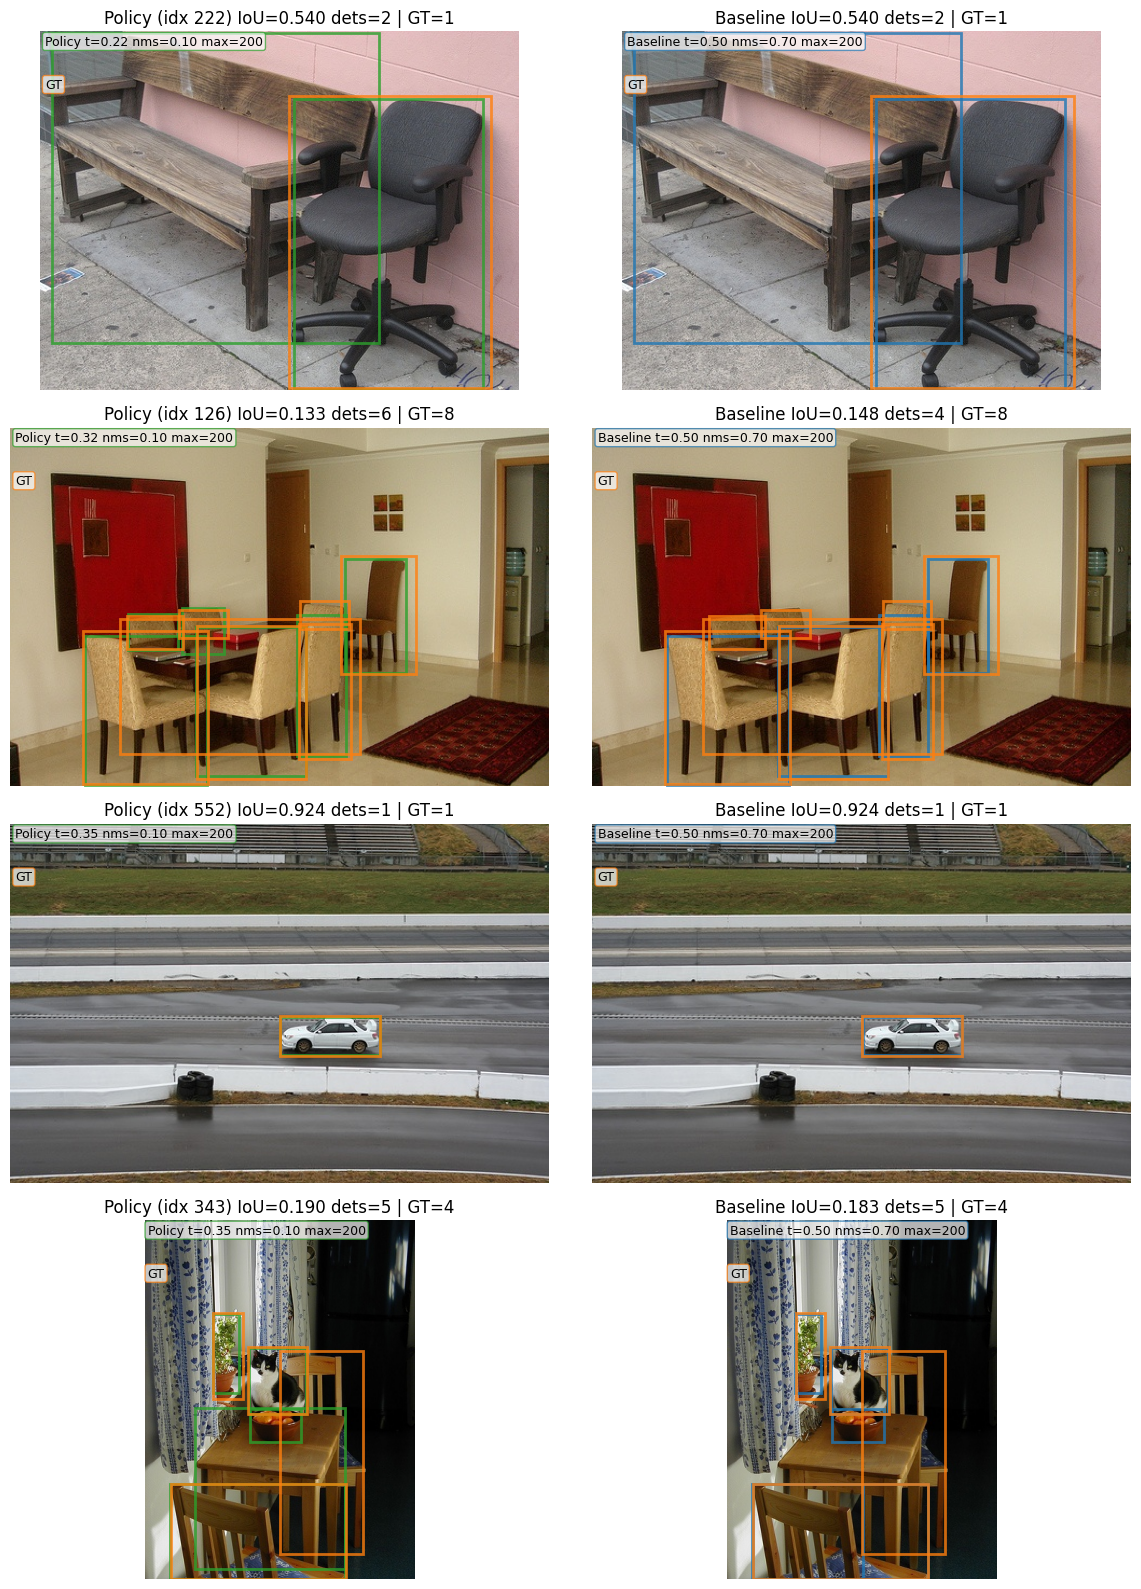

In [10]:
from utility.evaluation import visualize_policy_vs_baseline

fig = visualize_policy_vs_baseline(
    model,
    dataset,
    baseline_threshold=0.5,
    deterministic=True,
    device=POLICY_DEVICE,
    detector_device=DETECTOR_DEVICE,
)
